In [1]:
# TODO: Clean up this implementation!
!echo "Late updated:" `date`

Late updated: Mon Jul 27 22:00:33 PDT 2020


Changed: 
- Cleaned up code, removed some comments.

Things tried:
- Setting `dtype` to `np.float64` and  `np.float32`.
    - Some speedups were noticed with `np.float32`, but the quality of the inference seemed a little better with double precision.
- `tf.config.threading.set_inter_op_parallelism_threads(1)`. My thought was perhaps using multiple cores was affecting the timings. It wasn't really the case here.

In [2]:
# Import libraries.
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

# Default data type for tensorflow tensors.
dtype = np.float64
# dtype = np.float32

# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Set number of cores.
# tf.config.threading.set_inter_op_parallelism_threads(1)

Changed:
- Removed some comments. Cleaned up.

In [3]:
# Stick breaking function for DPGMM weights.
def stickbreak(v):
    batch_ndims = len(v.shape) - 1
    cumprod_one_minus_v = tf.math.cumprod(1 - v, axis=-1)
    one_v = tf.pad(v, [[0, 0]] * batch_ndims + [[0, 1]],
                   "CONSTANT", constant_values=1)
    c_one = tf.pad(cumprod_one_minus_v,
                   [[0, 0]] * batch_ndims + [[1, 0]],
                   "CONSTANT", constant_values=1)
    return one_v * c_one

Changed:
- Cleaned up code, removed some comments.

In [4]:
# See: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily
# See: https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model

# NOTE: This is just a Gaussian mixture model, but with the weights generated
# from a stickbreaking process.
def create_dp_sb_gmm(nobs, K, dtype=dtype):
    return tfd.JointDistributionNamed(dict(
        # Mixture means
        mu = tfd.Independent(
            tfd.Normal(np.zeros(K, dtype), 3),
            reinterpreted_batch_ndims=1
        ),
        # Mixture scales
        sigma = tfd.Independent(
            tfd.LogNormal(loc=np.full(K, - 2, dtype), scale=0.5),
            reinterpreted_batch_ndims=1
        ),
        # Mixture weights (stick-breaking construction)
        alpha = tfd.Gamma(concentration=dtype(1.0), rate=10.0),
        v = lambda alpha: tfd.Independent(
            # tfd.Beta(np.ones(K - 1, dtype), alpha),
            # NOTE: Dave Moore suggests doing this instead, to ensure 
            # that a batch dimension in alpha doesn't conflict with 
            # the other parameters.
            tfd.Beta(np.ones(K - 1, dtype), alpha[..., tf.newaxis]),
            reinterpreted_batch_ndims=1
        ),
        # Observations (likelihood)
        obs = lambda mu, sigma, v: tfd.Sample(tfd.MixtureSameFamily(
            # These Categorical variables will be marginalized over.
            mixture_distribution=tfd.Categorical(probs=stickbreak(v)),
            components_distribution=tfd.Normal(mu, sigma)),
            sample_shape=nobs)
    ))

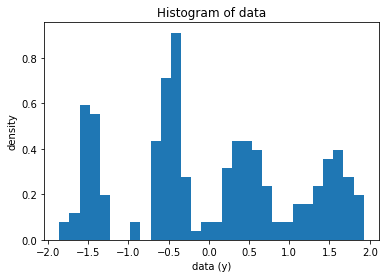

In [5]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
    simdata = json.load(f)

# Give data the correct type.
y = np.array(simdata['y'], dtype=dtype)

# Plot histogram of data.
plt.hist(y, density=True, bins=30)
plt.xlabel('data (y)')
plt.ylabel('density')
plt.title('Histogram of data');

In [6]:
# Helper for plotting posterior distribution of a given parameter.
def plot_param_post(param, param_name, param_full_name, level=95, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)
    
    ci_lower = (100 - level) / 2
    ci_upper = (100 + level) / 2

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[ci_lower, ci_upper], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    plt.subplot(1, 2, 2)
    plt.plot(param);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

In [7]:
# Helper for plotting posterior distribution of all model parameters.
def plot_all_params(output, target_logprob_fn):
    mu = output['mu'].numpy()
    sigma = output['sigma'].numpy()
    v = output['v']
    alpha = output['alpha'].numpy()
    eta = stickbreak(v).numpy()
    
    plot_param_post(eta, 'eta', 'mixture weights', truth=simdata['w'])
    plot_param_post(mu, 'mu', 'mixture locations', truth=simdata['mu'])
    plot_param_post(sigma, 'sigma', 'mixture scales', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(alpha, bins=30, density=True);
    plt.xlabel("alpha")
    plt.ylabel("density")
    plt.title("Posterior distribution of alpha"); 
    
    plt.subplot(1, 2, 2)
    # Plot log joint posterior (unnormalized)
    lp = [target_logprob_fn(mu=mu[i], sigma=sigma[i], alpha=alpha[i], v=v[i]) for i in range(len(mu))]
    lp = np.vstack(lp).ravel()
    plt.plot(lp)
    plt.xlabel("iteration (post-burn)")
    plt.ylabel("log joint posterior density (unnormalized)");

# Model Creation

In [8]:
# Number of mixture components.
ncomponents = 10

print('Create model ...')
model = create_dp_sb_gmm(nobs=len(simdata['y']), K=ncomponents)

print('Define log unnormalized joint posterior density ...')
def target_log_prob_fn(mu, sigma, alpha, v):
    return model.log_prob(obs=y, mu=mu, sigma=sigma, alpha=alpha, v=v)

Create model ...
Define log unnormalized joint posterior density ...


Changed:
- Added this cell. Running this cell before calling `sample_via_hmc()` (below) was necessary to successfully run `sample_via_hmc()`.

In [9]:
# NOTE: This seems to be necessary in order for dimensions
# to be correct. An error results if this is not executed
# before calling `sample_via_hmc()`.
_ = model.sample()

***
# MCMC

Changed:
- Cleaned up code.
-  `@tf.function(autograph=False)` ==> `@tf.function(autograph=False, experimental_compile=True)`

Question:
- What does `num_adaption_steps` specify for HMC?

In [10]:
# Create initial values.
initial_state = [
    tf.zeros(ncomponents, dtype, name='mu'),
    tf.ones(ncomponents, dtype, name='sigma') * 0.1,
    tf.ones([], dtype, name='alpha') * 0.5,
    tf.fill(ncomponents - 1, value=dtype(0.5), name='v')]

# Create bijectors.
bijectors = [
    tfb.Identity(),  # mu
    tfb.Exp(),  # sigma
    tfb.Exp(),  # alpha
    tfb.Sigmoid()  # v
]

# Improve performance by tracing the sampler using `tf.function`
# and compiling it using XLA.
@tf.function(autograph=False, experimental_compile=True)
def sample_via_hmc():
    return tfp.mcmc.sample_chain(
        num_results=500,
        num_burnin_steps=500,
        current_state=initial_state,
        kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=target_log_prob_fn,
                step_size=0.01,
                num_leapfrog_steps=100),
            bijector=bijectors),
        num_adaptation_steps=500),  # Question: What does this adapt in HMC?
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

## HMC

Question:
- Why am I getting the WARNINGS below? (I'll copy them in case you run these notebooks.)

Warnings:
```
Run HMC samplers ...
WARNING:tensorflow:From /home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/kernel.py:104: calling HamiltonianMonteCarlo.__init__ (from tensorflow_probability.python.mcmc.hmc) with step_size_update_fn is deprecated and will be removed after 2019-05-22.
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
WARNING:tensorflow:From /home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:507: calling HamiltonianMonteCarlo.__init__ (from tensorflow_probability.python.mcmc.hmc) with seed is deprecated and will be removed after 2020-09-20.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
CPU times: user 13.7 s, sys: 104 ms, total: 13.8 s
Wall time: 13.8 s
```

In [11]:
print('Run HMC samplers ...')
%time [mu, sigma, alpha, v], is_accepted = sample_via_hmc()  # Best: 14 seconds.

Run HMC samplers ...
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
CPU times: user 13.7 s, sys: 104 ms, total: 13.8 s
Wall time: 13.8 s


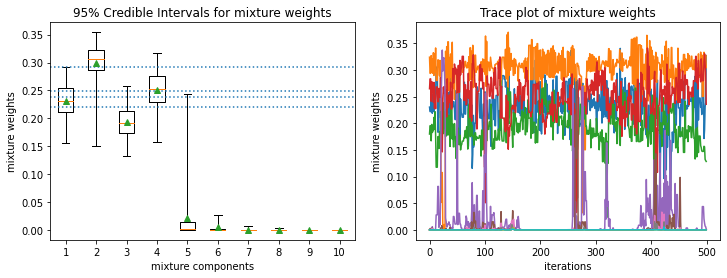

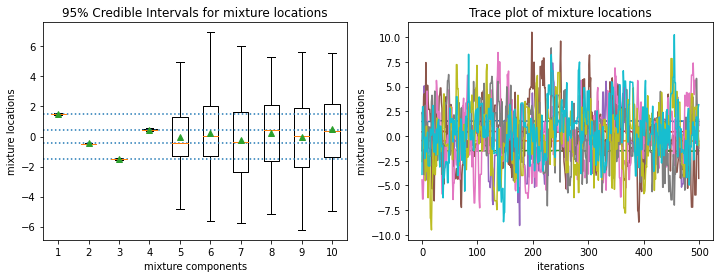

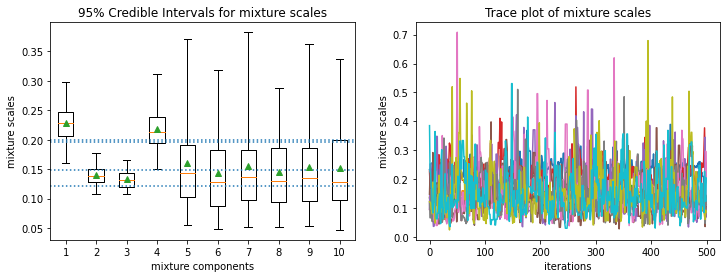

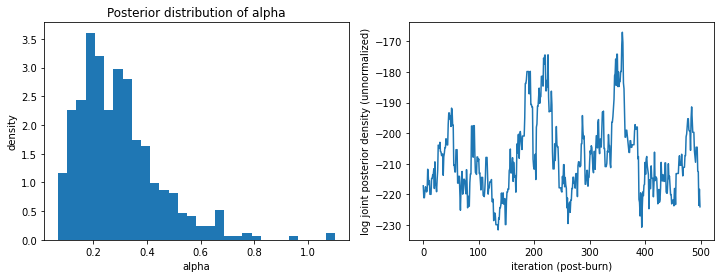

In [12]:
# HMC posterior inference
hmc_output = dict(mu=mu, sigma=sigma, alpha=alpha, v=v,
                  acceptance_rate=is_accepted.numpy().mean())
plot_all_params(hmc_output, target_log_prob_fn)